In [ ]:
place = "Tunis"
gdf = ox.geocoder.geocode_to_gdf(place)
osm_id = gdf.osm_id.loc[0]

In [ ]:
# Define a function to convert lists to strings (so we can save the building geodataframe because OSM includes a list of related nodes by default)
def convert_lists_to_strings(column):
    if column.dtype == 'object' and column.apply(lambda x: isinstance(x, list)).any():
        return column.apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else x)
    else:
        return column
    
    tags = {"building": True}
only_geometry = gdf.geometry
osm_id = gdf.osm_id.loc[0]

# TODO: make sure that if there are multiple polygons that we append the different building footprints. Right now we're saving over, right?
# Handle Single Geometry: If you need to handle a specific geometry (e.g., the first one), you can extract it using gdf.geometry.iloc[0].

# Iterate over each polygon in the GeoDataFrame
for polygon in gdf.geometry:
    if polygon.is_valid and isinstance(polygon, (Polygon, MultiPolygon)):
        try:
            buildings = ox.features_from_polygon(polygon, tags)
            save_dir = '../data/clean_data/solar/{OSMID}'
            save_dir = save_dir.format(OSMID=osm_id)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            save_dir = save_dir + f'/{osm_id}_buildings.gpkg'
            buildings = buildings.apply(convert_lists_to_strings, axis=0)
            buildings.to_file(save_dir, driver='GPKG')
            print(f'Success: Downloaded and saved {buildings.shape[0]} buildings.')
        except Exception as e:
            print(f"Error processing polygon: {e}")

In [ ]:
place = "Tunis"
gdf = ox.geocoder.geocode_to_gdf(place)
osm_id = gdf.osm_id.loc[0]

def generate_points_within_polygon(polygon, spacing, contains=True):
    min_x, min_y, max_x, max_y = polygon.bounds
    #TODO: Rethink the + spacing for within polygon
    # x_coords = np.arange(min_x - spacing, max_x + spacing, spacing)
    # y_coords = np.arange(min_y - spacing, max_y + spacing, spacing)
    # x_coords = np.arange(min_x, max_x + spacing, spacing)
    # y_coords = np.arange(min_y, max_y + spacing, spacing)
    x_coords = np.arange(min_x, max_x, spacing)
    y_coords = np.arange(min_y, max_y, spacing)
    
    points = []
    for x in x_coords:
        for y in y_coords:
            point = Point(x, y)
            if contains is True:
                if polygon.contains(point):
                    points.append(point)
            else:
                points.append(point)
    return points

def create_points_geodataframe(gdf, spacing, contains=True):
    all_points = []
    point_ids = []
    osm_ids = []
    point_id_counter = 1  # Initialize a counter for unique IDs
    
    for idx, row in gdf.iterrows():
        geom = row.geometry
        osm_id = row.osm_id
        
        if geom.geom_type == 'Polygon':
            points = generate_points_within_polygon(geom, spacing, contains)
            print(f"Generated {len(points)} points for Polygon with osm_id {osm_id}")
            all_points.extend(points)
            point_ids.extend([f"p_{point_id_counter + i}" for i in range(len(points))])
            osm_ids.extend([osm_id] * len(points))
            point_id_counter += len(points)
        elif geom.geom_type == 'MultiPolygon':
            for poly in geom.geoms:  # Use geom.geoms to iterate over the individual Polygons
                points = generate_points_within_polygon(poly, spacing, contains)
                print(f"Generated {len(points)} points for MultiPolygon with osm_id {osm_id}")
                all_points.extend(points)
                point_ids.extend([f"p_{point_id_counter + i}" for i in range(len(points))])
                osm_ids.extend([osm_id] * len(points))
                point_id_counter += len(points)
    
    points_gdf = gpd.GeoDataFrame({'geometry': all_points, 'id': point_ids, 'osm_id': osm_ids}, crs=gdf.crs)
    return points_gdf


def lat_lon_to_utm_epsg(min_x, min_y, max_x, max_y):
    """
    Convert latitude and longitude coordinates to the corresponding UTM projection crs.
    adapted from: https://pyproj4.github.io/pyproj/stable/examples.html#find-utm-crs-by-latitude-and-longitude
    """
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=min_x,
            south_lat_degree=min_y,
            east_lon_degree=max_x,
            north_lat_degree=max_y,
        ),
    )
    utm_crs = CRS.from_epsg(utm_crs_list[0].code)
    return utm_crs


# Check if the GeoDataFrame has a CRS defined
if gdf.crs is None:
    raise ValueError("Input GeoDataFrame does not have a CRS defined.")

# Define the spacing (150 meters in this case)
spacing = 450

# Reproject the GeoDataFrame to a projected CRS (e.g., UTM) if it is in a geographic CRS
if gdf.crs.is_geographic:
    # Grabs the overall bounding box so we can calculate which UTM zone we're in to reproject from a geographic to a projected CRS.
    bounds = gdf.bounds
    min_x = bounds['minx'].min()
    max_x = bounds['maxx'].max()
    min_y = bounds['miny'].min()
    max_y = bounds['maxy'].max()

    utm_crs = lat_lon_to_utm_epsg(min_x, min_y, max_x, max_y)
    projected_gdf = gdf.to_crs(utm_crs)
    print(f'Reprojected to {utm_crs}')
else:
    projected_gdf = gdf
    print(f'CRS was already projected')

print(projected_gdf.crs)

# Generate the points GeoDataFrame in the projected CRS
points_gdf = create_points_geodataframe(projected_gdf, spacing, contains=False)
print(points_gdf[0:5])
# points_gdf.plot()
# Reproject the points back to the original CRS so we can use it for the API query
if gdf.crs.is_geographic:
    points_gdf = points_gdf.to_crs(gdf.crs)

print(points_gdf.crs)
points_gdf.plot()
gdf.boundary.plot(ax=plt.gca(), color='red')
plt.show()


buffered_gdf = projected_gdf.copy()
buffered_gdf.geometry = buffered_gdf.geometry.buffer((spacing/2))
points_gdf = points_gdf.to_crs(buffered_gdf.crs)
intersecting_points = gpd.sjoin(points_gdf, buffered_gdf, how="inner", op="within")
intersecting_points = intersecting_points.drop('index_right', axis=1)

solar_coverage_high = gpd.read_file('../data/clean_data/solar/solar-api-coverage-032024/SolarAPIHighArea.shp')
# From: https://developers.google.com/maps/documentation/solar/coverage

solar_coverage_high.geometry = solar_coverage_high.geometry.to_crs(intersecting_points.crs)

intersecting_points = gpd.sjoin(intersecting_points, solar_coverage_high, how='inner',predicate='within')
print(len(intersecting_points))
intersecting_points.plot(figsize=(15,15))

935


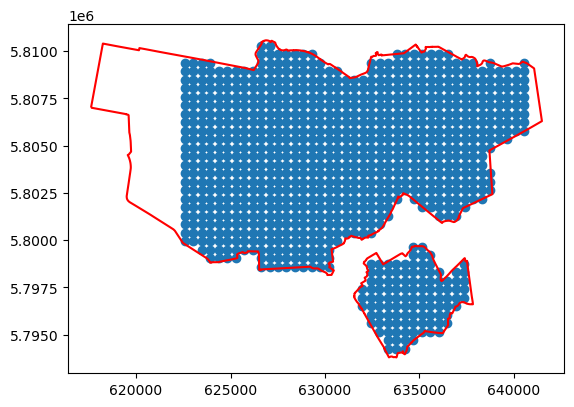

In [6]:
import osmnx as ox
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

def lat_lon_to_utm_epsg(min_x, min_y, max_x, max_y):
    """Convert latitude and longitude coordinates to the corresponding UTM projection CRS."""
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=min_x,
            south_lat_degree=min_y,
            east_lon_degree=max_x,
            north_lat_degree=max_y,
        ),
    )
    return CRS.from_epsg(utm_crs_list[0].code)

def generate_points_within_polygon(polygon, spacing, min_distance_boundary=None):
    """
    Generate points within a polygon with a specified spacing. Optionally filter points
    that are too close to a boundary defined by another geometry.
    """
    min_x, min_y, max_x, max_y = polygon.bounds
    x_coords = np.arange(min_x, max_x, spacing)
    y_coords = np.arange(min_y, max_y, spacing)

    points = [
        Point(x, y)
        for x in x_coords
        for y in y_coords
        if polygon.contains(Point(x, y))
    ]

    if min_distance_boundary is not None:
        boundary_buffer = min_distance_boundary.buffer(-spacing)
        points = [point for point in points if boundary_buffer.contains(point)]

    return points

def create_points_geodataframe(gdf, spacing, boundary=None):
    """
    Create a GeoDataFrame of points generated within geometries of an input GeoDataFrame.
    Optionally exclude points too close to a boundary defined by another GeoDataFrame.
    """
    all_points, point_ids, osm_ids = [], [], []
    point_id_counter = 1

    for _, row in gdf.iterrows():
        geom = row.geometry
        osm_id = row.osm_id

        if geom.geom_type == 'Polygon':
            points = generate_points_within_polygon(geom, spacing, boundary)
        elif geom.geom_type == 'MultiPolygon':
            points = [
                pt for poly in geom.geoms
                for pt in generate_points_within_polygon(poly, spacing, boundary)
            ]
        else:
            continue

        all_points.extend(points)
        point_ids.extend([f"p_{point_id_counter + i}" for i in range(len(points))])
        osm_ids.extend([osm_id] * len(points))
        point_id_counter += len(points)

    return gpd.GeoDataFrame({'geometry': all_points, 'id': point_ids, 'osm_id': osm_ids}, crs=gdf.crs)

def main():
    place = "Amsterdam"
    gdf = ox.geocoder.geocode_to_gdf(place)

    # Ensure CRS is defined
    if gdf.crs is None:
        raise ValueError("Input GeoDataFrame does not have a CRS defined.")

    # Define the spacing
    spacing = 450  # meters

    # Reproject to UTM if in geographic CRS
    if gdf.crs.is_geographic:
        bounds = gdf.bounds
        min_x, max_x = bounds['minx'].min(), bounds['maxx'].max()
        min_y, max_y = bounds['miny'].min(), bounds['maxy'].max()
        utm_crs = lat_lon_to_utm_epsg(min_x, min_y, max_x, max_y)
        gdf = gdf.to_crs(utm_crs)

    # Load SolarAPIHighArea and buffer for boundary consideration
    solar_coverage_high = gpd.read_file('../data/clean_data/solar/solar-api-coverage-032024/SolarAPIHighArea.shp')
    solar_coverage_high = solar_coverage_high.to_crs(gdf.crs)
    solar_boundary = solar_coverage_high.geometry.unary_union

    # Generate points
    points_gdf = create_points_geodataframe(gdf, spacing, boundary=solar_boundary)

    # Reproject back to geographic CRS if needed
    if gdf.crs.is_geographic:
        points_gdf = points_gdf.to_crs(gdf.crs)

    # Plot results
    points_gdf.plot()
    print(len(points_gdf))
    gdf.boundary.plot(ax=plt.gca(), color='red')
    plt.show()

    return points_gdf

if __name__ == "__main__":
    points = main()